<a href="https://githubtocolab.com/Astolfo2332/HyM_prediction/blob/main/0.3_Modelos_iniciales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Descarga de datos y su concatenación

In [ ]:
!pip install gdown
import gdown
gdown.download("https://drive.google.com/uc?export=download&id=1opKVgJeYVUxj_5VP81GgNkQ_76P_7j3l","./")
! unzip Dataset.zip

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import mean_squared_error,average_precision_score,mean_absolute_error,r2_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
dataset=pd.read_csv("data_set.csv")

In [3]:
dataset

,rebuy,customer_id,index_name,index_group_name,section_name,product_group_name,graphical_appearance_name,product_type_no,garment_group_name,product_type_name,perceived_colour_value_id
0,0,294,6,2,43,7,25,253,5,120,4
1,1,294,6,2,43,7,25,253,5,120,4
2,1,530,6,2,43,7,25,253,5,120,4
3,1,530,6,2,43,7,25,253,5,120,4
4,1,879,6,2,43,7,25,253,5,120,4
...,...,...,...,...,...,...,...,...,...,...,...
15894158,1,272379,6,2,53,5,25,265,6,32,4
15894159,1,290185,6,2,53,5,25,265,6,32,4
15894160,1,303378,6,2,53,5,25,265,6,32,4
15894161,1,974887,6,2,53,5,25,265,6,32,4


## 0.1 Ajuste del dataset

Debido a la gran cantidad de datos vamos a recortarlos para tener una mejor cantidad para no aumentar el gasto computacional

In [4]:
d=dataset[dataset["rebuy"]==1].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
dataset=pd.concat([dataset[dataset["rebuy"]==0],d[:100000]])
dataset

,rebuy,customer_id,index_name,index_group_name,section_name,product_group_name,graphical_appearance_name,product_type_no,garment_group_name,product_type_name,perceived_colour_value_id
0,0,294,6,2,43,7,25,253,5,120,4
5070,0,486,6,2,43,7,25,253,5,120,3
8463,0,2543,6,2,43,7,26,253,5,120,1
8575,0,11434,7,2,46,16,25,306,18,15,4
9085,0,6992,7,2,46,16,25,306,18,15,3
...,...,...,...,...,...,...,...,...,...,...,...
14962848,1,483611,6,2,43,7,26,254,5,107,4
640355,1,760669,4,1,9,12,25,87,10,14,1
12276639,1,1237042,6,2,53,5,25,265,6,32,1
3956645,1,493656,3,0,21,7,23,308,6,55,2


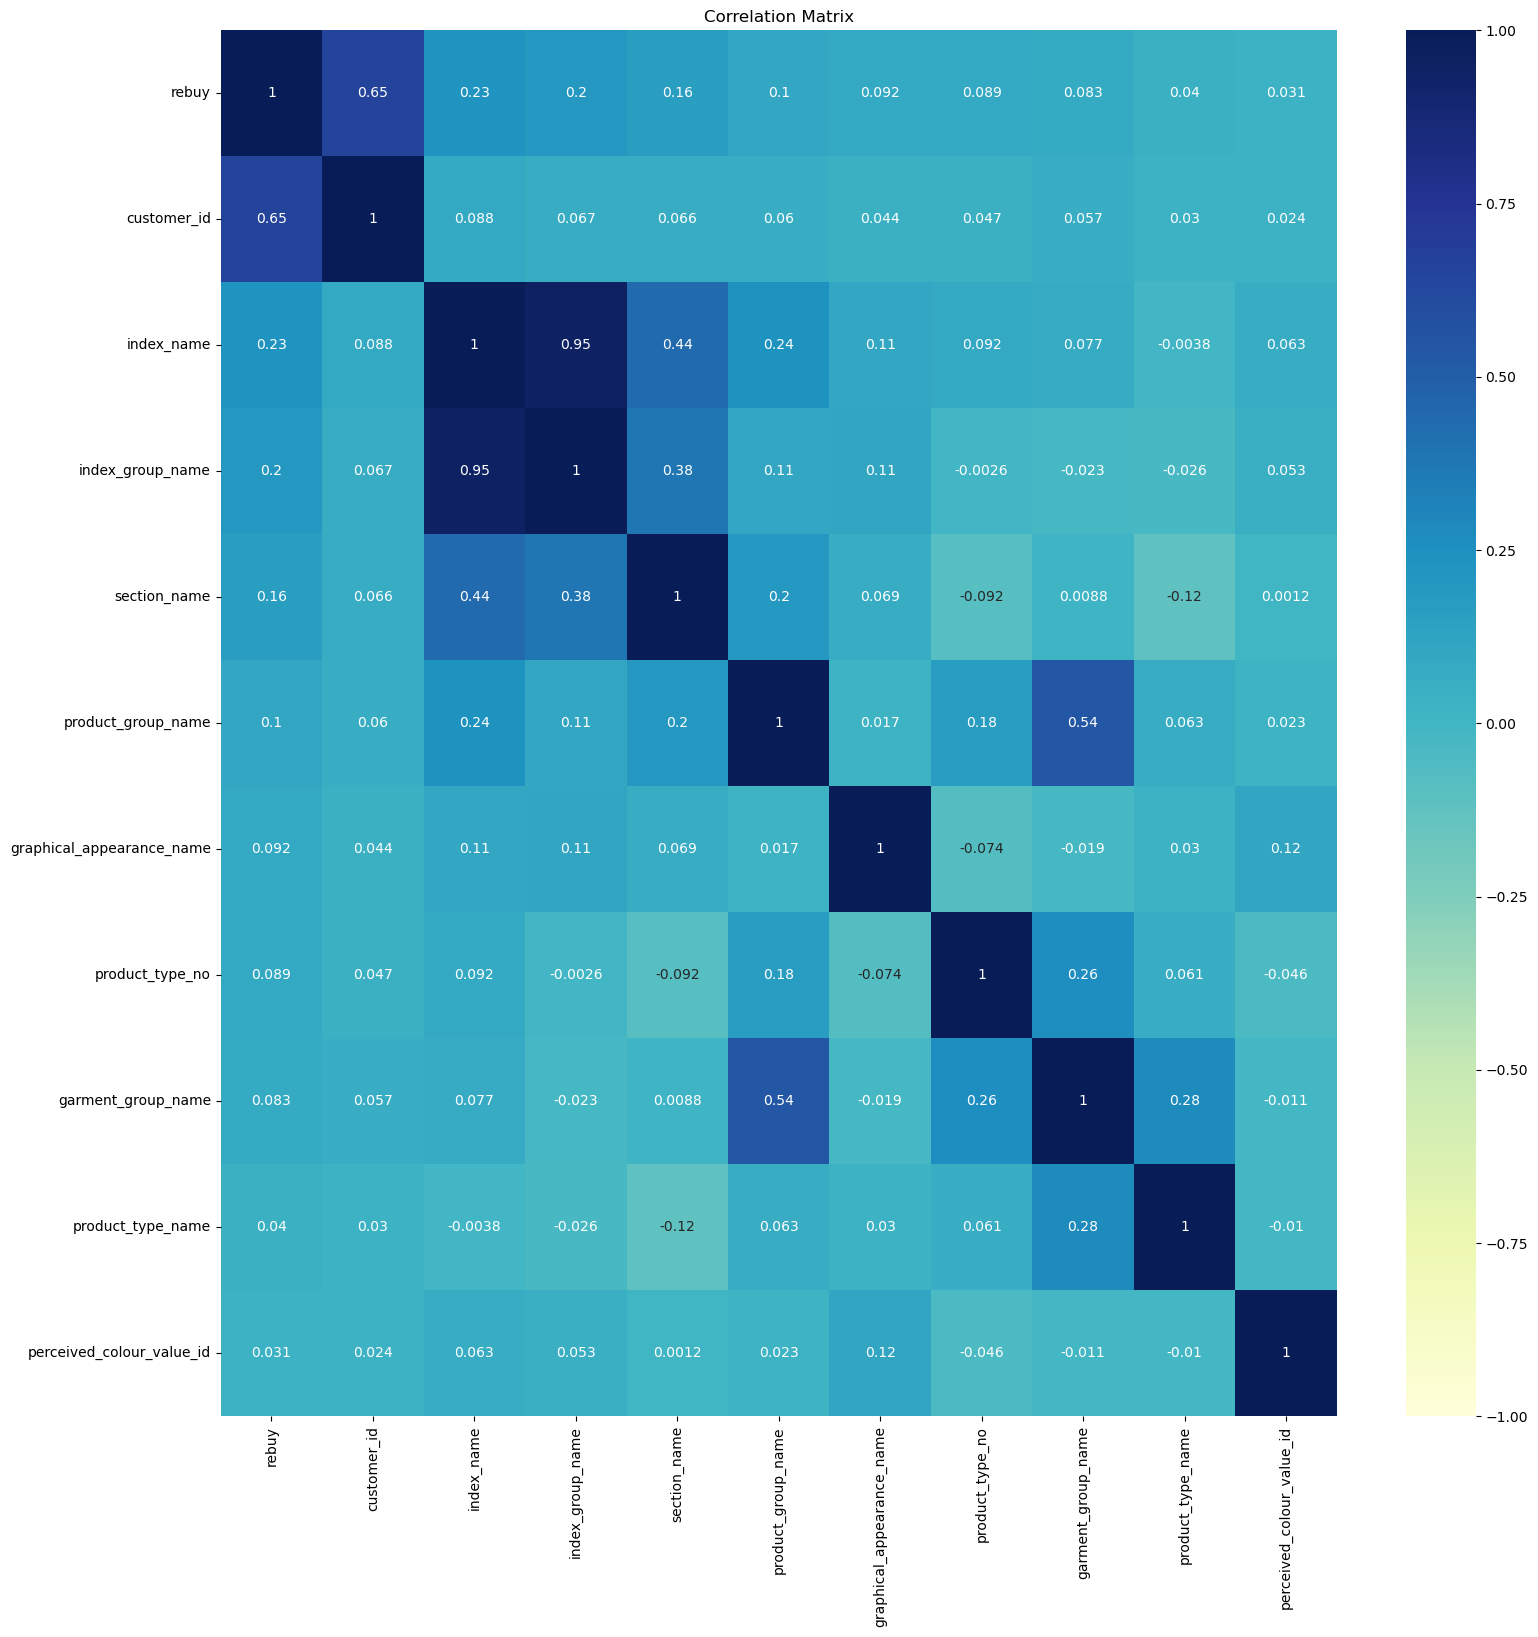

In [5]:
corr_matrix = dataset.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [6]:
target_corr_df = pd.DataFrame(corr_matrix["rebuy"].sort_values(ascending=False))
target_corr_df 

,rebuy
rebuy,1.000000
customer_id,0.650139
index_name,0.233954
index_group_name,0.200176
section_name,0.160276
product_group_name,0.104045
graphical_appearance_name,0.091762
product_type_no,0.088612
garment_group_name,0.083439
product_type_name,0.039586


## 0.2 Métricas

En este caso se usara el RMSE, debido a su validez y uso para problemas de regresión

In [7]:
x=dataset.drop(["rebuy"],axis=1)
y=dataset["rebuy"].values

En los casos anteriores se puede observar que los modelos obtienen mejores resultados dependiendo de la cantidad de datos, pero esto indicaría tener que adicionar muchos datos lo cual resultaría en un costo computacional elevado, para ello entonces se buscara un punto de equilibrio con la sección del código 0.1

# 2. Métodos supervisados

Métrica

In [40]:
def train_test_evaluate(model_name, model, X_train, y_train, X_test, y_test):  

    model.fit(X_train, y_train)
    
    y_pred= model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    r2 = r2_score(y_test, y_pred)
    y_test_mean= y_test.mean()
    mae_ratio= mae/y_test_mean
    rmse_ratio= rmse/y_test_mean
    
    result_df = pd.DataFrame(
        data=[[model_name, mae, mse, rmse, r2, mae_ratio, rmse_ratio]], 
        columns=["Model", 'MAE', 'MSE', 'RMSE', 'R2 Score', "MAE Ratio", "RMSE Ratio"])
    return result_df

In [8]:
def report_cv_score(z):
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [45]:
from sklearn.model_selection import train_test_split

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
scaler=StandardScaler()
Xtv=scaler.fit_transform(Xtv)
Xts=scaler.fit_transform(Xts)
print (Xtv.shape, Xts.shape)

(200614, 10) (200614,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(140429, 10) (60185, 10)


### 2.1 Mejor estimador:

In [46]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [47]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSE Test:  0.36599 (± 0.00062671 )
RMSE Train:  0.36620 (± 0.00047045 )
---------
RMSE Test:  0.27894 (± 0.00139321 )
RMSE Train:  0.27727 (± 0.00092338 )
---------
RMSE Test:  0.27758 (± 0.00094060 )
RMSE Train:  0.27636 (± 0.00101894 )
Seleccionado:  2

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


In [48]:
best_estimator

RandomForestRegressor(max_depth=5, n_estimators=2)

Así seleccionamos como mejor estimador Random Forest y procedemos a seleccionar los mejores hiperparámetros

### 2.2 RandomForest

In [13]:
from sklearn.model_selection import GridSearchCV

In [50]:
#Esta celda toma un tiempo considerable en completarse
parametros = {
    "n_estimators": list(range(80, 160, 20)),
    "max_depth": list(range(2, 20, 2)),
    "min_samples_leaf": list(range(1, 3)),
    "random_state": [23]
}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs=-1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [80, 100, 120, 140],
                         'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [51]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=12, min_samples_leaf=2, n_estimators=140,
                      random_state=23)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 140, 'random_state': 23}


In [52]:
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] ,max_depth = forest_reg.best_params_["max_depth"],min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],random_state=forest_reg.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=12, min_samples_leaf=2, n_estimators=140,
                      random_state=23)

In [53]:
print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))

RMSE del Random Forest en entrenamiento:  0.23414
RMSE del Random Forest seleccionado:  0.25972


In [54]:
result_df= train_test_evaluate("Random Forest", Rdm_forest, Xtv, ytv, Xts, yts)
result_df

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,Random Forest,0.135144,0.067454,0.259719,0.730175,0.271938,0.522607


## 3 Metodos no supervisados

### 3.1 PCA

In [55]:
from sklearn.decomposition import PCA
components = [1,3,5,7,9,10]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf_pca = [] 
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] ,max_depth = forest_reg.best_params_["max_depth"],min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],random_state=forest_reg.best_params_["random_state"])
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(x)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    Rdm_forest.fit(Xtv, ytv)
    perf_pca.append(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False))
    print('RMSE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))
    print('------------')
    
print('Mejor RMSE: ',"{:.5f}".format(np.min(perf_pca)),'  ; obtenido con ',components[np.argmin(perf_pca)],' componentes para PCA')
    

(140429, 1) (60185, 1)
RMSE del modelo con  1 elementos:  0.34505
------------
(140429, 3) (60185, 3)
RMSE del modelo con  3 elementos:  0.30541
------------
(140429, 5) (60185, 5)


KeyboardInterrupt: 

### 3.2 PCA+RandomForest

In [ ]:
#MEJOR PCA
pca = PCA(n_components = components[np.argmin(perf_pca)])
X_t1 = pca.fit_transform(x)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(140429, 10) (60185, 10)


In [ ]:
#Nota: Correr esta celda toma un tiempo considerable
forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 15, 20, 30, 40],
                         'n_estimators': [5, 10, 15, 20, 30, 40]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [ ]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=15, n_estimators=40)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 15, 'n_estimators': 40}


In [ ]:
#Mejor random forest para el PCA obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] ,max_depth = forest_reg.best_params_["max_depth"],min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],random_state=forest_reg.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

(140429, 10) (60185, 10)


RandomForestRegressor(max_depth=15, n_estimators=40)

In [ ]:
#Desempeño del modelo Random Forest seleccionado
print('RMSE Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))

RMSE Random Forest en entrenamiento:  0.20176
RMSE del Random Forest seleccionado:  0.26226


In [ ]:
result_df= train_test_evaluate("Random Forest+PCA", Rdm_forest, Xtv, ytv, Xts, yts)
result_df

### 3.2 NMF

Primeramente eliminamos las columnas con valores negativos

In [ ]:
numeric_columns = x.select_dtypes(include=[np.number])
negative_columns = numeric_columns.columns[numeric_columns.lt(0).any()]
x2=x.drop(negative_columns,axis=1)

In [ ]:
from sklearn.decomposition import NMF
test_size = 0.3
val_size  = test_size/(1-test_size)
perf_nmf = [] #desempeños de los modelos
Des_tree = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] ,max_depth = forest_reg.best_params_["max_depth"],min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],random_state=forest_reg.best_params_["random_state"])
for i in components:
    nmf = NMF(n_components = i)
    X_t = nmf.fit_transform(x2)
    
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Des_tree.fit(Xtv, ytv)
    perf_nmf.append(mean_squared_error(yts , Des_tree.predict(Xts),squared=False))
    print('RMSE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Des_tree.predict(Xts),squared=False)))
    print('------------')

print('Mejor RMSE: ',"{:.5f}".format(np.min(perf_nmf)),'  ; obtenido con ',components[np.argmin(perf_nmf)],' componentes para NMF')

(140429, 1) (60185, 1)
RMSE del modelo con  1 elementos:  0.34503
------------
(140429, 3) (60185, 3)
RMSE del modelo con  3 elementos:  0.32139
------------
(140429, 5) (60185, 5)
RMSE del modelo con  5 elementos:  0.31943
------------
(140429, 7) (60185, 7)
RMSE del modelo con  7 elementos:  0.32326
------------
(140429, 9) (60185, 9)
RMSE del modelo con  9 elementos:  0.32393
------------


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


(140429, 10) (60185, 10)
RMSE del modelo con  10 elementos:  0.26598
------------
Mejor RMSE:  0.26598   ; obtenido con  10  componentes para PCA


In [ ]:
#MEJOR NMF
test_size = 0.3
val_size  = test_size/(1-test_size)
nmf = NMF(n_components = components[np.argmin(perf_nmf)])
X_t2 = nmf.fit_transform(x2)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(140429, 10) (60185, 10)


### 3.2.1 NMF+RandomForest

In [ ]:
forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 15, 20, 30, 40],
                         'n_estimators': [5, 10, 15, 20, 30, 40]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [ ]:
print("Mejor estimador Random forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para Random forest: ", forest_reg.best_params_)

Mejor estimador Decision Tree:  RandomForestRegressor(max_depth=15, n_estimators=40)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 15, 'n_estimators': 40}


In [ ]:
#Mejor Decision Tree para el NMF obtenido
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] ,max_depth = forest_reg.best_params_["max_depth"],min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],random_state=forest_reg.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=15, n_estimators=40)

In [ ]:
print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error((ytv) , (Rdm_forest.predict(Xtv)))))
print('RMSE del Random Fores seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts))))

RMSE del Random Forest en entrenamiento:  0.06996
RMSE del Random Fores seleccionado:  0.10798


In [ ]:
result_df= train_test_evaluate("Random Forest+NMF", Rdm_forest, Xtv, ytv, Xts, yts)
result_df

# 4. Curvas de aprendizaje

Para conocer el valor de datos necesarios para entrenar un buen modelo, o ver como responden los diferentes algoritmos a la cantidad de datos de este problema, se realizaran curvas para observar su comportamiento y así evaluar si se necesita agregar más datos

## 4.1 Método supervisado

In [ ]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

En este caso lo hacemos con Random Forest debido a que fue el modelo con mejor desempeño

In [ ]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación

print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(200614, 10) (200614,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(140429, 10) (60185, 10)


In [ ]:
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] ,max_depth = forest_reg.best_params_["max_depth"],min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],random_state=forest_reg.best_params_["random_state"])

### 4.1.1 Random Forest

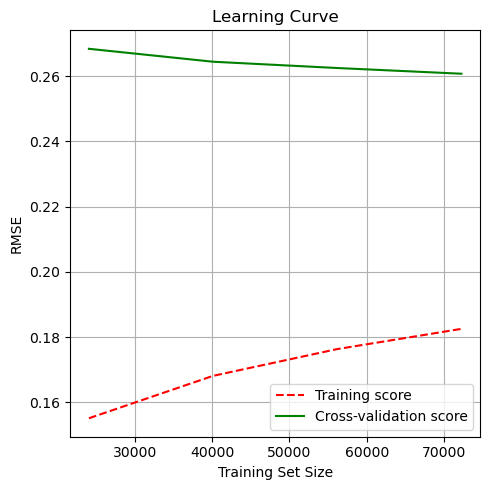

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
lc_plot(Rdm_forest,Xtv,ytv)

### 4.2 Métodos no supervisados

### 4.2.1 Random Forest y PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = components[np.argmin(perf_pca)])
X_t1 = pca.fit_transform(x)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] ,max_depth = forest_reg.best_params_["max_depth"],min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],random_state=forest_reg.best_params_["random_state"])

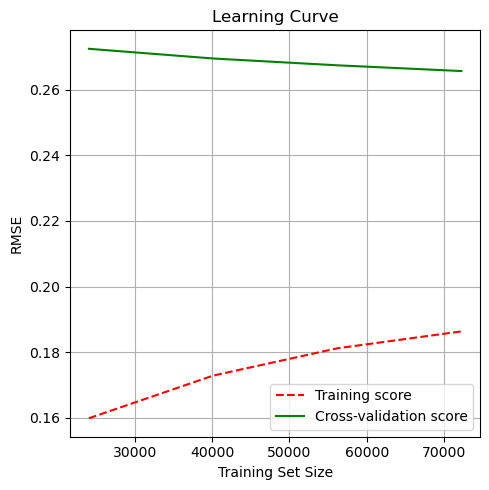

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
lc_plot(Rdm_forest,Xtv,ytv)

### 4.2.2 NMF y Random Forest

In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = components[np.argmin(perf_nmf)])
X_t2 = nmf.fit_transform(x2)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)

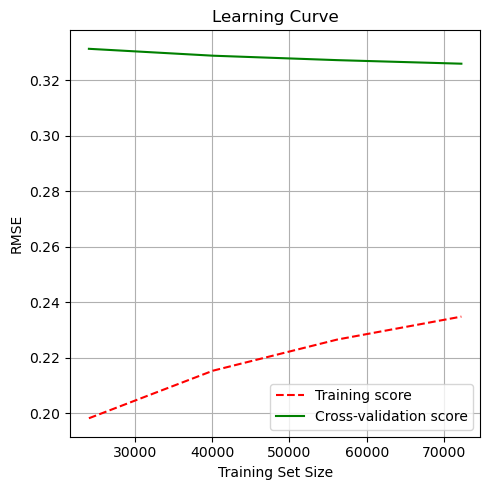

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
lc_plot(Rdm_forest,Xtv,ytv)